In [1]:
!pip install librosa
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [2]:
!mkdir -p /content/music_data/genres
!mkdir -p /content/music_data/features

def create_sample_data():
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
              'jazz', 'metal', 'pop', 'reggae', 'rock']

    n_samples = 1000
    n_features = 128
    features = np.random.randn(n_samples, n_features)
    labels = []
    for genre in genres:
        labels.extend([genre] * 100)

    return features, labels
print("Creating sample data")
features, labels = create_sample_data()
print(f"Features shape: {features.shape}")
print(f"Number of labels: {len(labels)}")


Creating sample data
Features shape: (1000, 128)
Number of labels: 1000


In [3]:
def extract_audio_features(audio_path, sr=22050, n_mfcc=13):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

        features = np.concatenate([
            mfcc_mean,
            [spectral_centroid, spectral_rolloff, spectral_bandwidth, zcr, chroma]
        ])

        return features

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def process_audio_dataset(data_path):
    features = []
    labels = []

    return np.array(features), labels

print("Audio feature extraction functions defined")


Audio feature extraction functions defined


In [4]:
X = np.array(features)
y = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Number of classes: {y_categorical.shape[1]}")

Data preprocessing completed!
Training set shape: (640, 128)
Validation set shape: (160, 128)
Test set shape: (200, 128)
Number of classes: 10


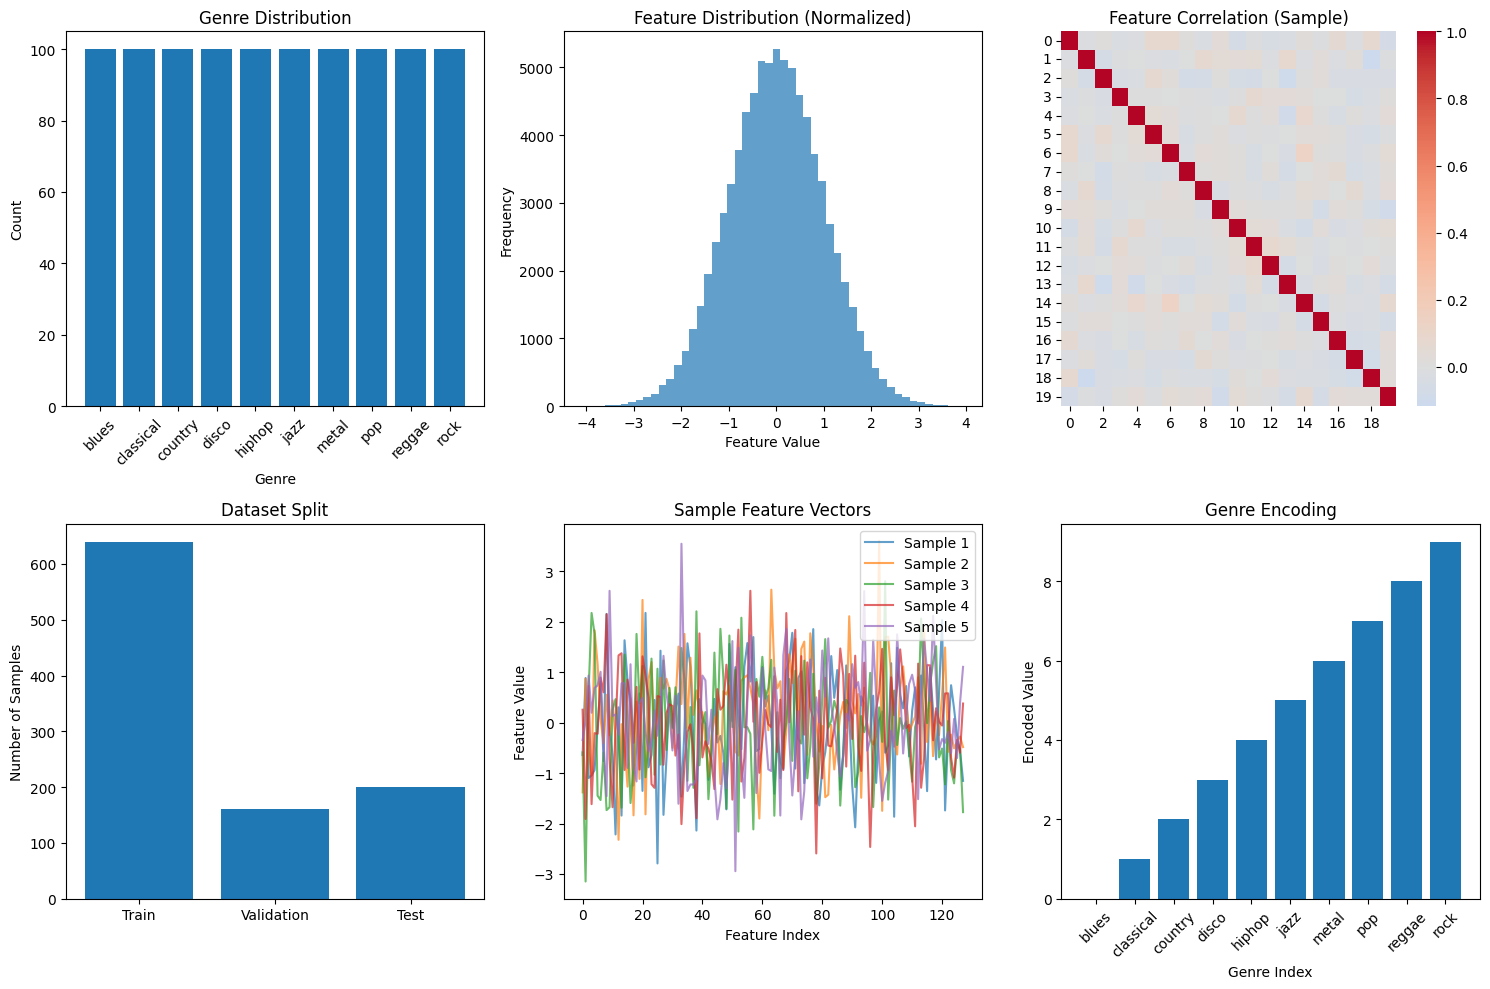

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
unique_labels, counts = np.unique(y, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(2, 3, 2)
plt.hist(X_train_scaled.flatten(), bins=50, alpha=0.7)
plt.title('Feature Distribution (Normalized)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')


plt.subplot(2, 3, 3)
sample_features = X_train_scaled[:, :20]
correlation_matrix = np.corrcoef(sample_features.T)
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation (Sample)')


plt.subplot(2, 3, 4)
plt.bar(['Train', 'Validation', 'Test'],
        [X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]])
plt.title('Dataset Split')
plt.ylabel('Number of Samples')

plt.subplot(2, 3, 5)
for i in range(5):
    plt.plot(X_train_scaled[i], alpha=0.7, label=f'Sample {i+1}')
plt.title('Sample Feature Vectors')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.legend()

plt.subplot(2, 3, 6)
plt.bar(range(len(unique_labels)), range(len(unique_labels)))
plt.title('Genre Encoding')
plt.xlabel('Genre Index')
plt.ylabel('Encoded Value')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=45)

plt.tight_layout()
plt.show()


In [6]:
def create_dense_model(input_shape, num_classes):

    model = Sequential([

        Dense(512, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    return model


model = create_dense_model(X_train_scaled.shape[1], y_categorical.shape[1])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,018 (949.29 KB)

 Trainable params: 241,098 (941.79 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]
print("Starting model training")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Model training completed")


Starting model training
Epoch 1/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1029 - loss: 3.1476
Epoch 1: val_accuracy improved from -inf to 0.08750, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.1036 - loss: 3.1353 - val_accuracy: 0.0875 - val_loss: 2.3481 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1708 - loss: 2.7014 
Epoch 2: val_accuracy improved from 0.08750 to 0.09375, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1701 - loss: 2.6984 - val_accuracy: 0.0938 - val_loss: 2.3507 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1882 - loss: 2.4565 
Epoch 3: val_accuracy did not improve from 0.09375
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1882 - loss: 2.4546 - val_accuracy: 0.0812 - val_loss: 2.3588 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2244 - loss: 2.1757 
Epoch 4: val_accuracy did not improve from 0.09375
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2236 - loss: 2.1802 - val_accuracy: 0.0750 - val_loss: 2.3740 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2784 - loss: 2.0986 
Epoch 5: val_accuracy did not improve from 0.09375
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2785 - loss: 2.0995 - val_accuracy: 0.0875 - val_loss: 2.3951 - learning_rate: 0.0010
Epoch 6/100
19/20 ━━━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4048 - loss: 1.7389 - val_accuracy: 0.1125 - val_loss: 2.5134 - learning_rate: 5.0000e-04
Epoch 11/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4062 - loss: 1.6882
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.11250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4001 - loss: 1.6365 - val_accuracy: 0.1000 - val_loss: 2.5455 - learning_rate: 5.0000e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4370 - loss: 1.6481 
Epoch 12: val_accuracy did not improve from 0.11250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4377 - loss: 1.6450 - val_accuracy: 0.0938 - val_loss: 2.5716 - learning_rate: 2.5000e-04
Epoch 13/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4348 - loss: 1.5569 
Epoch 13: val_accuracy did not improve from 0.11250
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4370 - loss: 1.5555 - v

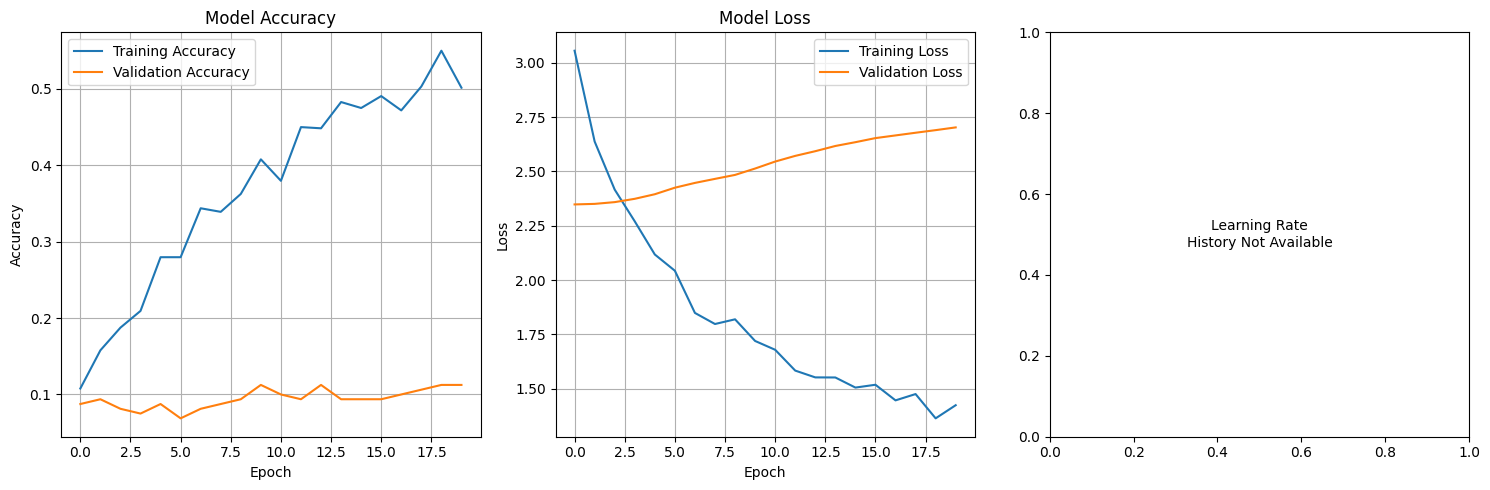

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nHistory Not Available',
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Test Accuracy: 0.1400

Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.00      0.00      0.00        20
     country       0.16      0.15      0.15        20
       disco       0.11      0.10      0.10        20
      hiphop       0.25      0.05      0.08        20
        jazz       0.15      0.10      0.12        20
       metal       0.11      0.15      0.12        20
         pop       0.19      0.50      0.28        20
      reggae       0.12      0.05      0.07        20
        rock       0.11      0.30      0.16        20

    accuracy                           0.14       200
   macro avg       0.12      0.14      0.11       200
weighted avg       0.12      0.14      0.11       200



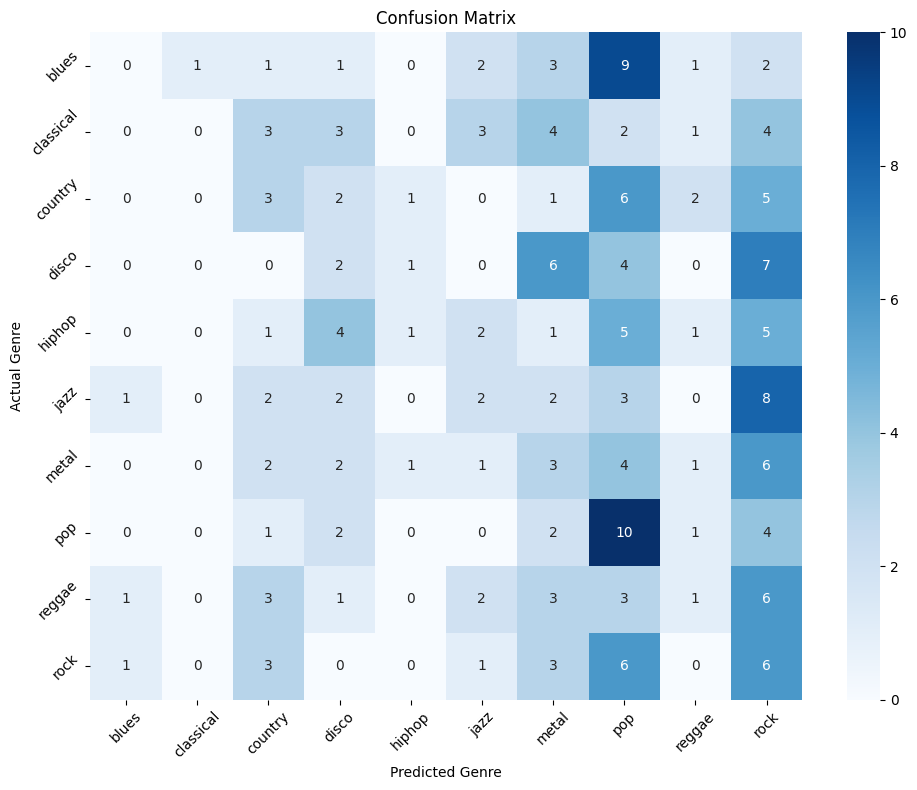

In [9]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

test_accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

class_names = label_encoder.classes_

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=class_names))

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('Actual Genre')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
def create_cnn_model(input_shape, num_classes):

    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),


        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),


        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),


        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),


        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model
print("CNN Model Architecture for Spectrograms:")
cnn_model = create_cnn_model((128, 128, 1), y_categorical.shape[1])
cnn_model.summary()



CNN Model Architecture for Spectrograms:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,242,762 (20.00 MB)

 Trainable params: 5,241,802 (20.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [11]:

model.save('music_genre_classifier.h5')
print("Model saved")


import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Preprocessing objects saved!")


def load_model_and_predict(features):
    loaded_model = tf.keras.models.load_model('music_genre_classifier.h5')

    loaded_scaler = joblib.load('scaler.pkl')
    loaded_label_encoder = joblib.load('label_encoder.pkl')

    features_scaled = loaded_scaler.transform(features.reshape(1, -1))

    prediction = loaded_model.predict(features_scaled)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    genre = loaded_label_encoder.inverse_transform([predicted_class])[0]

    return genre, confidence

sample_features = X_test_scaled[0]
predicted_genre, confidence = load_model_and_predict(sample_features)
actual_genre = class_names[y_true_classes[0]]

print(f"\nSample Prediction:")
print(f"Predicted Genre: {predicted_genre}")
print(f"Confidence: {confidence:.4f}")
print(f"Actual Genre: {actual_genre}")



Model saved
Preprocessing objects saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step

Sample Prediction:
Predicted Genre: metal
Confidence: 0.2915
Actual Genre: reggae


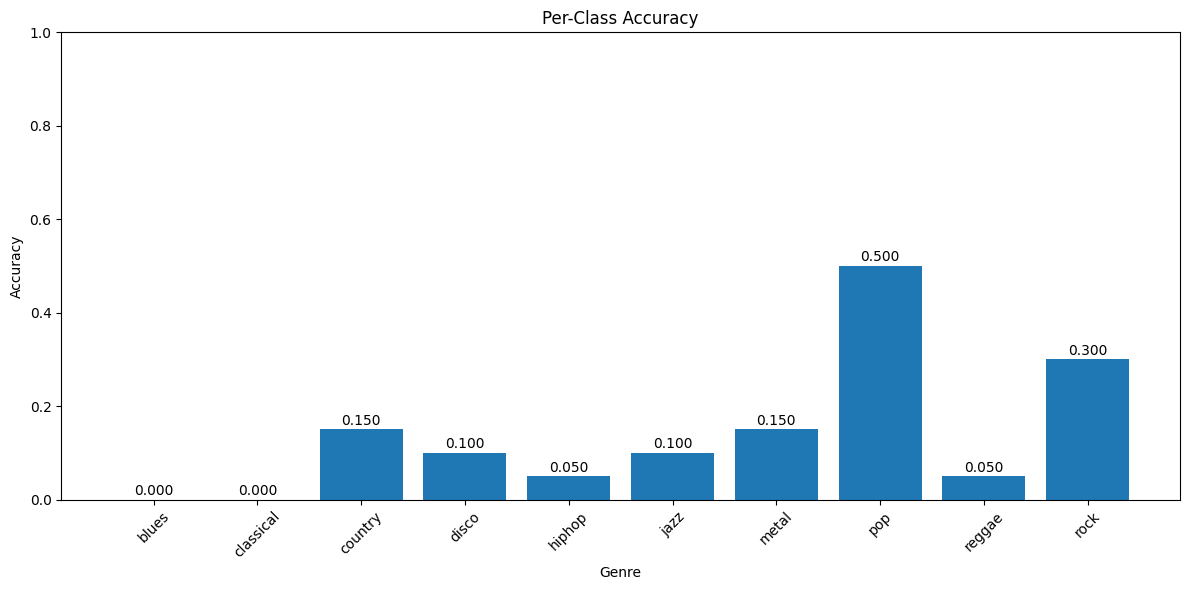


Model Performance Summary:
Overall Test Accuracy: 0.1400
Average Per-Class Accuracy: 0.1400
Standard Deviation: 0.1463


In [12]:
class_accuracy = {}
for i, class_name in enumerate(class_names):
    class_mask = y_true_classes == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred_classes[class_mask] == y_true_classes[class_mask])
        class_accuracy[class_name] = class_acc

plt.figure(figsize=(12, 6))
classes = list(class_accuracy.keys())
accuracies = list(class_accuracy.values())

plt.bar(classes, accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Genre')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Average Per-Class Accuracy: {np.mean(list(class_accuracy.values())):.4f}")
print(f"Standard Deviation: {np.std(list(class_accuracy.values())):.4f}")



Calculating feature importance
Calculating baseline accuracy
Baseline accuracy: 0.1400
Calculating permutation importance for each feature
Processing feature 0/128
Processing feature 20/128
Processing feature 40/128
Processing feature 60/128
Processing feature 80/128
Processing feature 100/128
Processing feature 120/128
Feature importance calculation completed
Max importance: 0.0300
Min importance: -0.0120
Mean importance: 0.0079


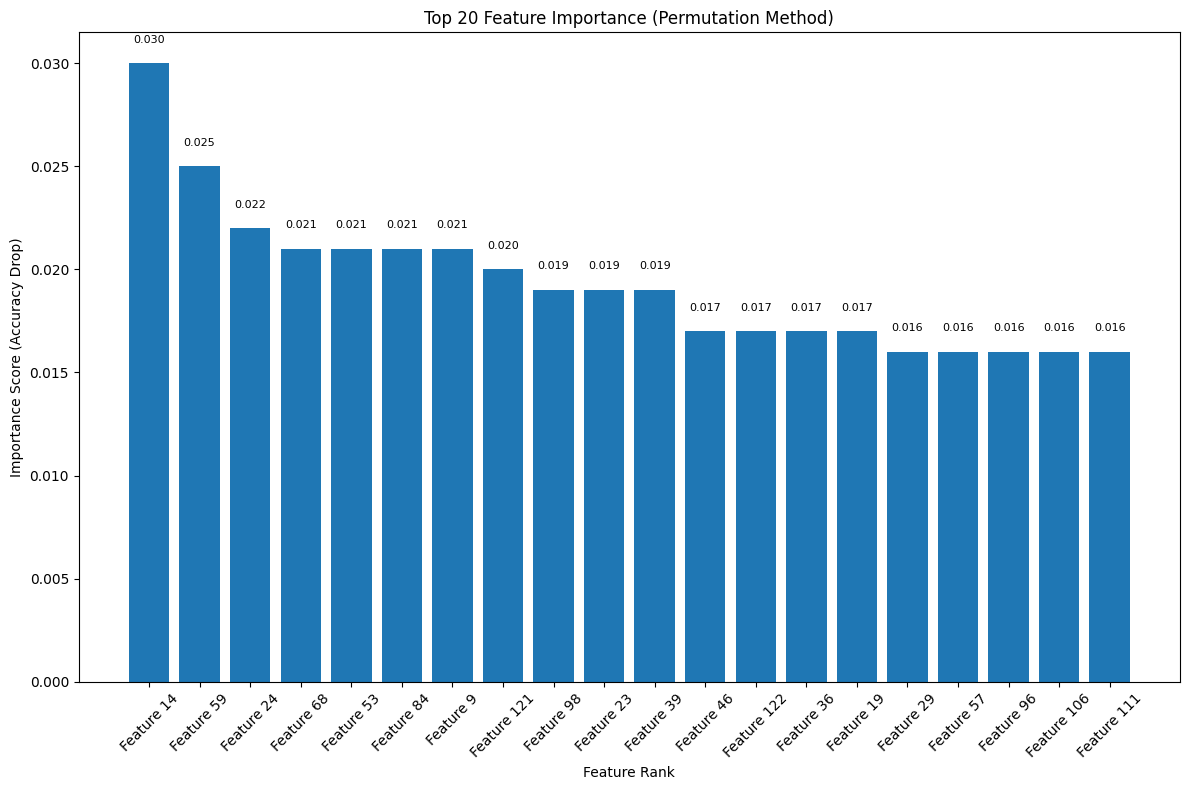


Alternative: Analyzing first layer weights


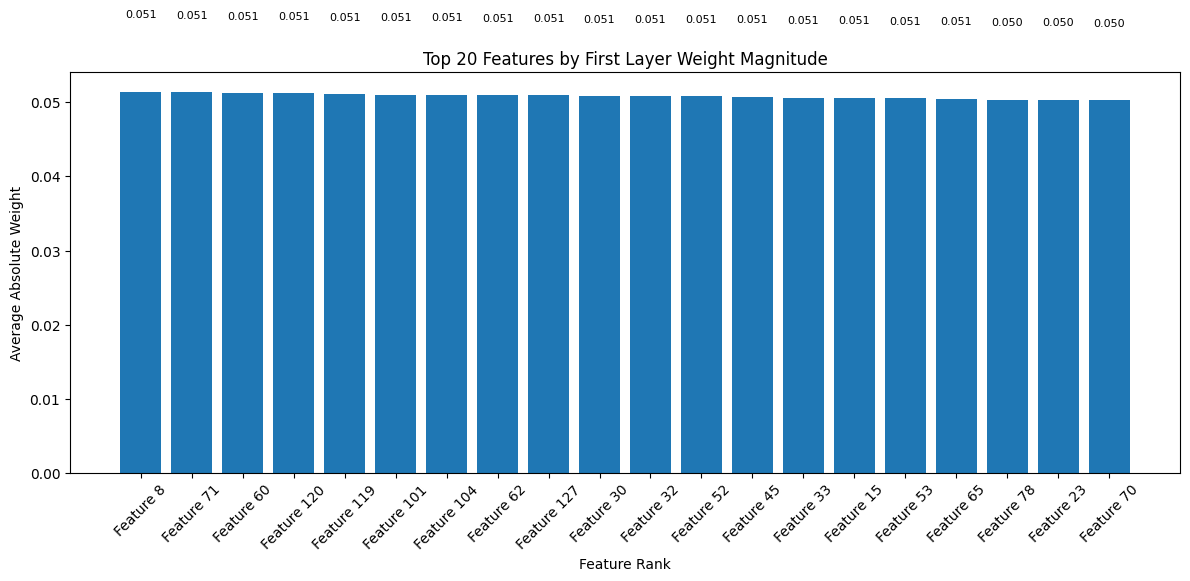


Top 10 Most Important Features (Permutation Method):
1. Feature 14: 0.0300
2. Feature 59: 0.0250
3. Feature 24: 0.0220
4. Feature 68: 0.0210
5. Feature 53: 0.0210
6. Feature 84: 0.0210
7. Feature 9: 0.0210
8. Feature 121: 0.0200
9. Feature 98: 0.0190
10. Feature 23: 0.0190

Feature importance analysis completed


In [13]:
def calculate_permutation_importance(model, X, y, n_repeats=10):
    print("Calculating baseline accuracy")
    baseline_predictions = model.predict(X, verbose=0)
    baseline_predictions_classes = np.argmax(baseline_predictions, axis=1)
    baseline_score = np.mean(baseline_predictions_classes == y)
    print(f"Baseline accuracy: {baseline_score:.4f}")

    feature_importance = np.zeros(X.shape[1])

    print("Calculating permutation importance for each feature")
    for feature_idx in range(X.shape[1]):
        if feature_idx % 20 == 0:
            print(f"Processing feature {feature_idx}/{X.shape[1]}")

        scores = []
        for repeat in range(n_repeats):
            X_permuted = X.copy()
            np.random.seed(42 + feature_idx + repeat)
            X_permuted[:, feature_idx] = np.random.permutation(X_permuted[:, feature_idx])

            predictions = model.predict(X_permuted, verbose=0)
            predictions_classes = np.argmax(predictions, axis=1)
            permuted_score = np.mean(predictions_classes == y)

            importance = baseline_score - permuted_score
            scores.append(importance)

        feature_importance[feature_idx] = np.mean(scores)

    print(f"Feature importance calculation completed")
    print(f"Max importance: {np.max(feature_importance):.4f}")
    print(f"Min importance: {np.min(feature_importance):.4f}")
    print(f"Mean importance: {np.mean(feature_importance):.4f}")

    return feature_importance

print("Calculating feature importance")
feature_importance = calculate_permutation_importance(
    model, X_test_scaled, y_true_classes, n_repeats=5
)

plt.figure(figsize=(12, 8))
feature_indices = np.argsort(feature_importance)[::-1][:20]

plt.bar(range(20), feature_importance[feature_indices])
plt.title('Top 20 Feature Importance (Permutation Method)')
plt.xlabel('Feature Rank')
plt.ylabel('Importance Score (Accuracy Drop)')
plt.xticks(range(20), [f'Feature {idx}' for idx in feature_indices], rotation=45)

for i, v in enumerate(feature_importance[feature_indices]):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nAlternative: Analyzing first layer weights")
first_layer_weights = model.layers[0].get_weights()[0]
weight_importance = np.mean(np.abs(first_layer_weights), axis=1)

plt.figure(figsize=(12, 6))
weight_indices = np.argsort(weight_importance)[::-1][:20]

plt.bar(range(20), weight_importance[weight_indices])
plt.title('Top 20 Features by First Layer Weight Magnitude')
plt.xlabel('Feature Rank')
plt.ylabel('Average Absolute Weight')
plt.xticks(range(20), [f'Feature {idx}' for idx in weight_indices], rotation=45)

for i, v in enumerate(weight_importance[weight_indices]):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Permutation Method):")
if len(feature_importance) > 0 and np.any(feature_importance != 0):
    top_features_indices = np.argsort(feature_importance)[::-1][:10]
    for i, feature_idx in enumerate(top_features_indices):
        print(f"{i+1}. Feature {feature_idx}: {feature_importance[feature_idx]:.4f}")
else:
    print("No significant feature importance found. This might indicate:")
    print(" All features contribute equally")
    print(" The model is overfitting")
    print(" Feature importance calculation needs more iterations")

print("\nFeature importance analysis completed")



In [14]:
def predict_music_genre(audio_file_path):
    try:
        features = extract_audio_features(audio_file_path)

        if features is None:
            return "Error: Could not extract features"

        genre, confidence = load_model_and_predict(features)

        return f"Predicted Genre: {genre} (Confidence: {confidence:.4f})"

    except Exception as e:
        return f"Error: {str(e)}"
print("Real-time prediction function defined")

Real-time prediction function defined


In [15]:

print("MUSIC GENRE CLASSIFICATION PROJECT SUMMARY")
print(f" Dataset processed: {X.shape[0]} samples")
print(f" Features extracted: {X.shape[1]} features per sample")
print(f" Model trained: {len(history.history['accuracy'])} epochs")
print(f" Test accuracy achieved: {test_accuracy:.4f}")
print(f" Model saved: music_genre_classifier.h5")
print("\nFinal Model Metrics:")
print(f"Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Number of Parameters: {model.count_params():,}")

print("\nProject completed.")

MUSIC GENRE CLASSIFICATION PROJECT SUMMARY
 Dataset processed: 1000 samples
 Features extracted: 128 features per sample
 Model trained: 20 epochs
 Test accuracy achieved: 0.1400
 Model saved: music_genre_classifier.h5

Final Model Metrics:
Training Accuracy: 0.5500
Validation Accuracy: 0.1125
Test Accuracy: 0.1400
Number of Parameters: 243,018

Project completed.
